# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

42020


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook and chromosome size

## Codebook

**Codebook** example from [codebook_link](../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## Chromosome size by radius gyration

Data below can be generated using the notebook as:

[]()

In [9]:
chrom_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312\chromatin_property'
chromosome_size_df = pd.read_csv(os.path.join(chrom_folder, 'WT_MOp_Rg.csv'), index_col=0)

chromosome_size_df.head()

,rg,uid,majorType,subclass,chr,fiberidx
0,1.241714,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr1,1
1,1.163226,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr10,1
2,1.888276,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr11,1
3,1.759560,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr12,1
4,1.404082,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr13,1


# 3. Chromosome size and nucleus size

## Load nucleus size

Data below can be generated using the notebook as:

[3_nuclei_size_by_convexhull_singlecell_dataframe](3_nuclei_size_by_convexhull_singlecell_dataframe.ipynb)

In [10]:
nuc_size_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v0\Nuclear_organization\analysis'
nuc_size_fname = os.path.join(nuc_size_folder, f'nucleus_volume_convexhull_bysubclass.csv')

merged_cell_volume_df = pd.read_csv(nuc_size_fname, index_col=0)
merged_cell_volume_df

,subclass,nucleus_volume,total_spots
uid,,,
259202492748634617304623818845147108919,Oligo,255.043678,863
336074706103419484501535095917410831417,Oligo,298.589934,1426
179117357717369278884189379535888871018,Oligo,305.797609,1601
36321914521561890358202806077673807953,Oligo,76.777445,210
92271180002801802991585284299263797402,Oligo,376.983590,2034
...,...,...,...
89559371323596133331060964655277765256,VLMC,183.802964,584
144314319466287448491677682735506973,VLMC,92.940088,387
71119619609696733523981100580894538756,VLMC,237.601248,734


## Correlation of all celltypes

In [11]:
min_pts_th = 1250
df_plot = merged_cell_volume_df[merged_cell_volume_df['total_spots']>min_pts_th]
df_plot_median = pd.DataFrame(df_plot.groupby(by='subclass')['nucleus_volume'].median())
# add chromosome size by celltype
df_plot_median['chromosome_size'] = chromosome_size_df.groupby(by='subclass')['rg'].median()
df_plot_median['celltype'] = df_plot_median.index
df_plot_median

,nucleus_volume,chromosome_size,celltype
subclass,,,
Astro,285.322546,1.309265,Astro
Endo,217.164786,1.230019,Endo
L2/3 IT,465.983908,1.446868,L2/3 IT
L4/5 IT,397.141421,1.382461,L4/5 IT
L5 ET,585.822123,1.641963,L5 ET
L5 IT,484.328127,1.507216,L5 IT
L5/6 NP,409.405376,1.424335,L5/6 NP
L6 CT,416.260699,1.367400,L6 CT
L6 IT,452.559266,1.402383,L6 IT


meta NOT subset; don't know how to subset; dropped


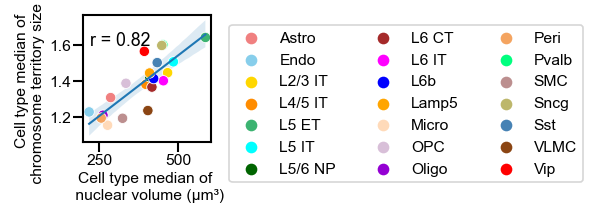

In [13]:
# plot
%matplotlib inline
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(figsize=(_page_width/5,_page_width/5),dpi=150)

x_col = 'nucleus_volume'
y_col = 'chromosome_size'


# correlation
X=df_plot_median[x_col].values.reshape(-1, 1)
y=df_plot_median[y_col].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)
y_pred = reg.predict(X)
#ax.plot(X,y_pred,'r--',alpha=0.6)

gfg = sns.regplot(data=df_plot_median, x= x_col, y = y_col, ax=ax,
                  ci=95,scatter=False,
                  line_kws={'linewidth':1}
                 )
gfg = sns.scatterplot(data=df_plot_median, 
                      x= x_col, y = y_col, ax=ax,
                        #legend='full',
                        hue ='celltype',
                      #linewidth = 0,
                        palette=celltype_palette,
                        s=25,
                   )

plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left', ncols=3, borderaxespad=1,fontsize=_font_size)
#ax.text(220,1.6,f'r\u00b2 = {round(reg.score(X, y),2)}',fontsize=_font_size)

from scipy.stats import pearsonr
r_val = pearsonr(df_plot_median[x_col].values, df_plot_median[y_col].values)[0]
ax.text(220,1.6,f'r = {round(r_val,2)}',fontsize=_font_size+1)


ax.tick_params('x', labelsize=_font_size, 
                    #width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for _ax
ax.tick_params('y', labelsize=_font_size, 
                #width=_ticklabel_width, #length=0,
                pad=1, labelleft=True)

#ax.set_xlabel(f'nucleus size -median', fontsize=_font_size, labelpad=5)
ax.set_xlabel('Cell type median of \n nuclear volume (\u03bcm\u00b3)',fontsize=_font_size,labelpad=2)

ax.set_ylabel(f'Cell type median of \n chromosome territory size (Rg)', fontsize=_font_size, labelpad=2)


ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'Corr_Nucleus_ConvexHull_and_Chromosome_Rg.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()
    

# 4. Chromosome size and gene expression

## Load 10x snRNA

Data below can be generated by the notebook as (with transfer cell type labels to the filtered adata)

[external/scripts/sn_rna/2_prepare_and_rename_sn_rna_mop](../../external/scripts/sn_rna/2_prepare_and_rename_sn_rna_mop.ipynb)


In [14]:
sn_RNA_folder = r'L:\Shiwei\DNA_MERFISH_analysis\10x_nuclei_v3_MOp_AIBS\Analysis_10X_nuclei_v3_AIBS\processed'
sn_adata = sc.read(os.path.join(sn_RNA_folder,r'MOp_10x_sn_filtered_unnorm_w_label.h5ad'))

#sn_adata_ori = sn_adata.raw.to_adata()

## Transcripts' genomic information

Example table can be found as:

[MOp_10x_snRNA_chr_info_NEW_from_transcriptome_FORMAT](../../external/resources/MOp_10x_snRNA_chr_info_NEW_from_transcriptome_FORMAT.csv)

In [15]:
clean_gene_df =pd.read_csv(os.path.join(sn_RNA_folder, "MOp_10x_snRNA_chr_info_NEW_from_transcriptome_FORMAT.csv"), index_col=0)
clean_gene_df

,chr,start,end,gene_biotype,coding_strand,length,genomic_position
gene,,,,,,,
Xkr4,1,3205901,3671498,protein_coding,-1,465597,chr1_3205901_3671498
Gm1992,1,3466587,3513553,antisense,1,46966,chr1_3466587_3513553
Gm37381,1,3905739,3986215,lincRNA,-1,80476,chr1_3905739_3986215
Rp1,1,3999557,4409241,protein_coding,-1,409684,chr1_3999557_4409241
Sox17,1,4490931,4497354,protein_coding,-1,6423,chr1_4490931_4497354
...,...,...,...,...,...,...,...
mt-Nd4l,MT,9877,10173,protein_coding,1,296,chrMT_9877_10173
mt-Nd4,MT,10167,11544,protein_coding,1,1377,chrMT_10167_11544
mt-Nd5,MT,11742,13565,protein_coding,1,1823,chrMT_11742_13565


In [16]:
sn_adata.var[clean_gene_df.columns]=clean_gene_df
sn_adata.var

,gene_ids,feature_types,genome,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,chr,start,end,gene_biotype,coding_strand,length,genomic_position
Xkr4,ENSMUSG00000051951,Gene Expression,mm10-3.0.0_premrna,56494,39642,18.981079,1.304586,762394.0,1,3205901.0,3671498.0,protein_coding,-1.0,465597.0,chr1_3205901_3671498
Gm1992,ENSMUSG00000089699,Gene Expression,mm10-3.0.0_premrna,27826,22458,1.614375,44.087039,64843.0,1,3466587.0,3513553.0,antisense,1.0,46966.0,chr1_3466587_3513553
Gm37381,ENSMUSG00000102343,Gene Expression,mm10-3.0.0_premrna,531,402,0.011378,98.999154,457.0,1,3905739.0,3986215.0,lincRNA,-1.0,80476.0,chr1_3905739_3986215
Rp1,ENSMUSG00000025900,Gene Expression,mm10-3.0.0_premrna,2526,1941,0.055171,95.167555,2216.0,1,3999557.0,4409241.0,protein_coding,-1.0,409684.0,chr1_3999557_4409241
Sox17,ENSMUSG00000025902,Gene Expression,mm10-3.0.0_premrna,40,20,0.002714,99.950207,109.0,1,4490931.0,4497354.0,protein_coding,-1.0,6423.0,chr1_4490931_4497354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.2,ENSMUSG00000094915,Gene Expression,mm10-3.0.0_premrna,7,6,0.000149,99.985062,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC168977.1,ENSMUSG00000079808,Gene Expression,mm10-3.0.0_premrna,30,25,0.000697,99.937758,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC149090.1,ENSMUSG00000095041,Gene Expression,mm10-3.0.0_premrna,63283,39257,12.481999,2.263108,501352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,mm10-3.0.0_premrna,6785,4887,0.193447,87.832993,7770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
chrom_list = [c for c in np.unique(codebook_df['chr']) if c!= 'Y']
chrom_list = [c for c in chrom_list  if c!='X']
chrom_list.sort(key = int)
chrom_list.append('X')


filtered_adata = sn_adata[:,sn_adata.var['chr'].isin(chrom_list)]
filtered_adata

View of AnnData object with n_obs × n_vars = 40166 × 24561
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'subclass_label', 'class_label', 'cluster_label', 'cluster_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'neuron_identity', 'class_label_new', 'subclass_label_new'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts',

## Append average gene expression for chromosome

In [18]:
#sel_celltype = 'L2/3 IT'
groupby = 'subclass_label_new'

#sel_adata = filtered_adata[filtered_adata.obs[groupby]==sel_celltype]

expression_chr_dict = {'celltype':[], 'chr':[], 
                       'chrom_size':[],#'chrom_size_bySlope':[],
                       'chromosome_expression':[],#'log10_chromosome_expression':[],
                      }
import tqdm
#sel_chrom = 'chr4'
for sel_chrom in tqdm.tqdm(chrom_list):
    sel_chrom = f'chr{sel_chrom}'
    chromosome_size_df_chr = chromosome_size_df[chromosome_size_df['chr']==sel_chrom]

    for sel_celltype in np.unique(chromosome_size_df['subclass'].tolist())[:]:
    #for _chr in chrom_list:
        sel_adata = filtered_adata[filtered_adata.obs[groupby]==sel_celltype]
        sel_adata_chr = sel_adata[:, sel_adata.var['chr']==sel_chrom.split('chr')[1]]
        #est_chrom_len = np.max(sel_adata_chr.var['end'])

        #expression_mean = np.nanmean(sel_adata_chr.X.toarray())
        #expression_median = np.nanmedian(sel_adata_chr.X.toarray())
        expression_celltype = np.nanmedian(np.sum(sel_adata_chr.X.toarray(),axis=1))
        chr_size_celltype = np.nanmedian(chromosome_size_df_chr[chromosome_size_df_chr['subclass']==sel_celltype]['rg'])
        #chr_size_celltype_bySlope = cis_res_df.loc[sel_celltype][f'{sel_chrom}_slope']
        expression_chr_dict['celltype'].append(sel_celltype)
        expression_chr_dict['chr'].append(sel_chrom)
        expression_chr_dict['chrom_size'].append(chr_size_celltype)
        #expression_chr_dict['chrom_size_bySlope'].append(chr_size_celltype_bySlope)
        expression_chr_dict['chromosome_expression'].append(expression_celltype)
        #expression_chr_dict['log10_chromosome_expression'].append(np.log10(expression_celltype))
    
expression_chr_df = pd.DataFrame(expression_chr_dict)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:45<00:00,  2.26s/it]


## Plot scatter

In [19]:
Gluta_list = ['L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b',]
Gluta_list2 = ['L2/3 IT', 'L4/5 IT',  'L5 IT', 'L6 IT','L5 ET',
       'L6 CT',  'L6b',]

GABA_list = ['Sst, Sncg','Vip','Pvalb','Lamp5']
NonNeu_list = ['Astro', 'Endo','Micro', 'OPC', 'Oligo', 'Peri', 'SMC', 'VLMC']

### each chromosome separately for all cells

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]meta NOT subset; don't know how to subset; dropped


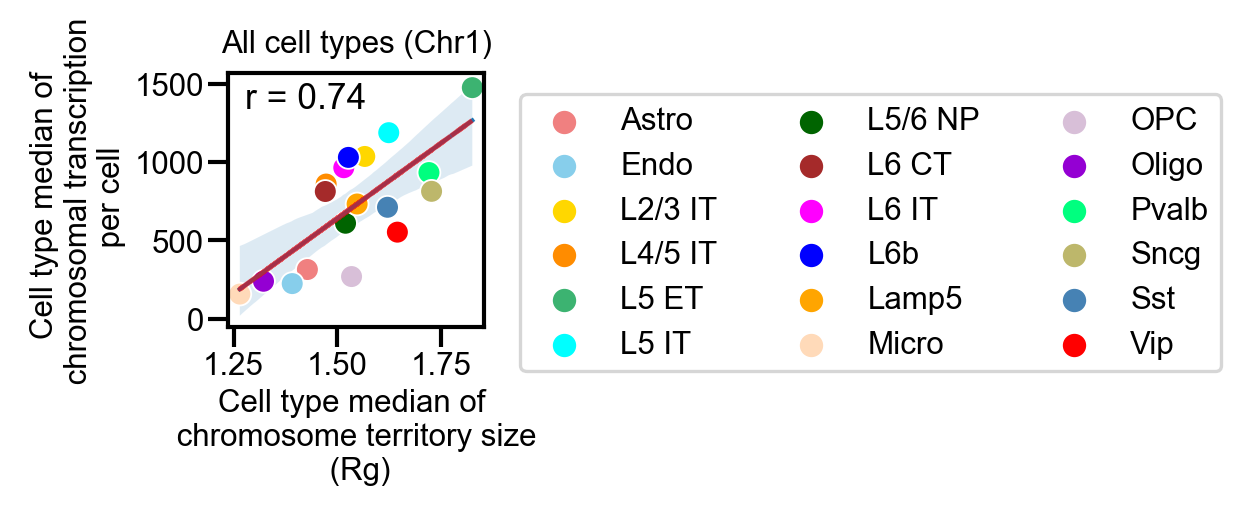

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.91s/it]meta NOT subset; don't know how to subset; dropped


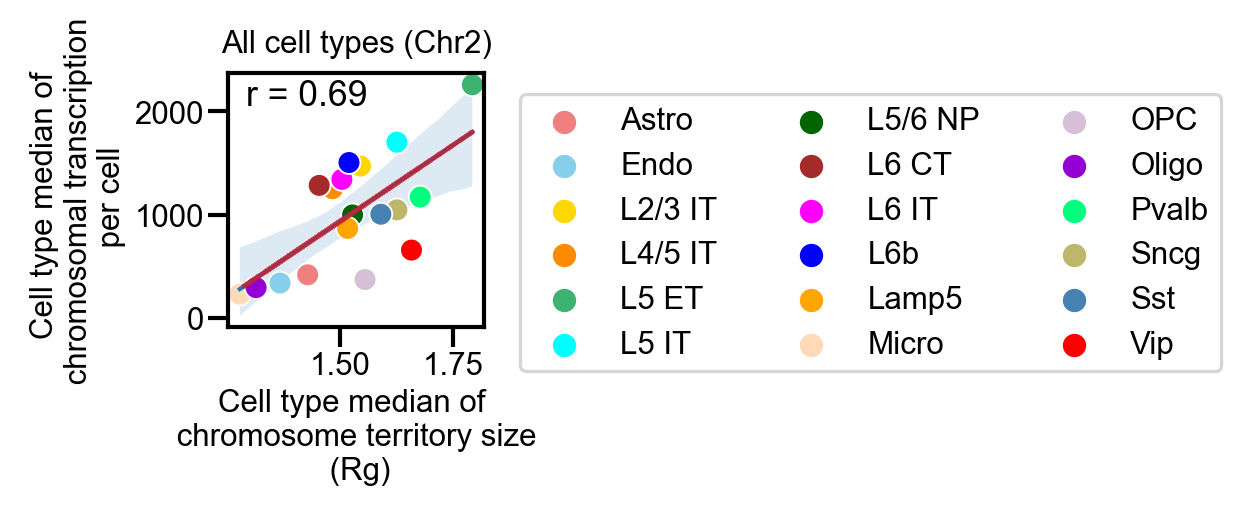

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.83s/it]meta NOT subset; don't know how to subset; dropped


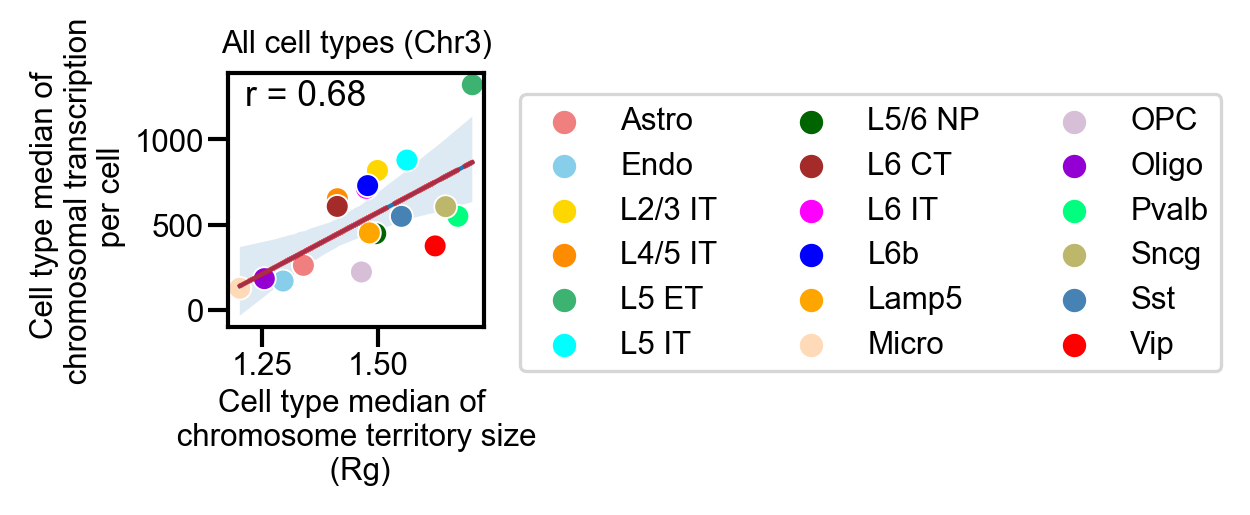

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.86s/it]


In [21]:
%matplotlib inline
import seaborn as sns

sel_chrom_list = ['1','2','3']
for sel_chrom in tqdm.tqdm(sel_chrom_list):
    sel_chrom = f'chr{sel_chrom}'
    expression_chr_df_sub = expression_chr_df[expression_chr_df['chr']==sel_chrom]
    #expression_chr_df_sub = expression_chr_df_sub [expression_chr_df_sub ['celltype'].isin(Gluta_list2)].copy(deep=True)
    expression_chr_df_sub=expression_chr_df_sub.dropna()
    fig, ax = plt.subplots(figsize=(_page_width/5,_page_width/5),dpi=300)
    
    x_col = 'chrom_size'
    
    gfg = sns.regplot(data=expression_chr_df_sub, x= x_col, y='chromosome_expression', ax=ax, ci=95,
                  line_kws={'linewidth':1},scatter=False,
                 )
    sns.scatterplot(ax=ax, data=expression_chr_df_sub, x=x_col,y='chromosome_expression',
                        hue='celltype', legend = 'brief', palette=celltype_palette,
                    s=30)
    ax.set_title(f'{sel_chrom}',fontsize=_font_size)

    # correlation
    X=expression_chr_df_sub[x_col].values.reshape(-1, 1)
    y=expression_chr_df_sub['chromosome_expression'].values.reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True).fit(X, y)
    y_pred = reg.predict(X)
    ax.plot(X,y_pred,'r--',alpha=0.6)
    rPlot_x,rPlot_y = np.nanmin(X)*1.01, np.nanmax(y)*.91
    #ax.text(rPlot_x,rPlot_y,f'r\u00b2 = {round(reg.score(X, y),2)}',fontsize=_font_size)
    
    from scipy.stats import pearsonr
    r_val = pearsonr(expression_chr_df_sub[x_col].values, expression_chr_df_sub['chromosome_expression'].values)[0]
    ax.text(rPlot_x,rPlot_y,f'r = {round(r_val,2)}',fontsize=_font_size+1)

    
    plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left', borderaxespad=1,fontsize=_font_size,ncols=3)
    ax.set_ylabel('Cell type median of \n chromosomal transcription \n per cell',fontsize=_font_size,labelpad=2)
    ax.set_xlabel(f'Cell type median of \n chromosome territory size \n (Rg)', fontsize=_font_size, labelpad=2)
    
    ax.set_title(f'All cell types ({sel_chrom.capitalize()})',fontsize=_font_size,pad=5)
    
    ax.tick_params('x', labelsize=_font_size, 
                    #width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for _ax
    ax.tick_params('y', labelsize=_font_size, 
                #width=_ticklabel_width, #length=0,
                pad=1, labelleft=True)

    plt.savefig(os.path.join(output_figure_folder, f'Corr_Chromosome_Rg_and_Transcription_{sel_chrom}.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

    #plt.tight_layout()
    plt.show()

### each chromosome separately for Gluta

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]meta NOT subset; don't know how to subset; dropped


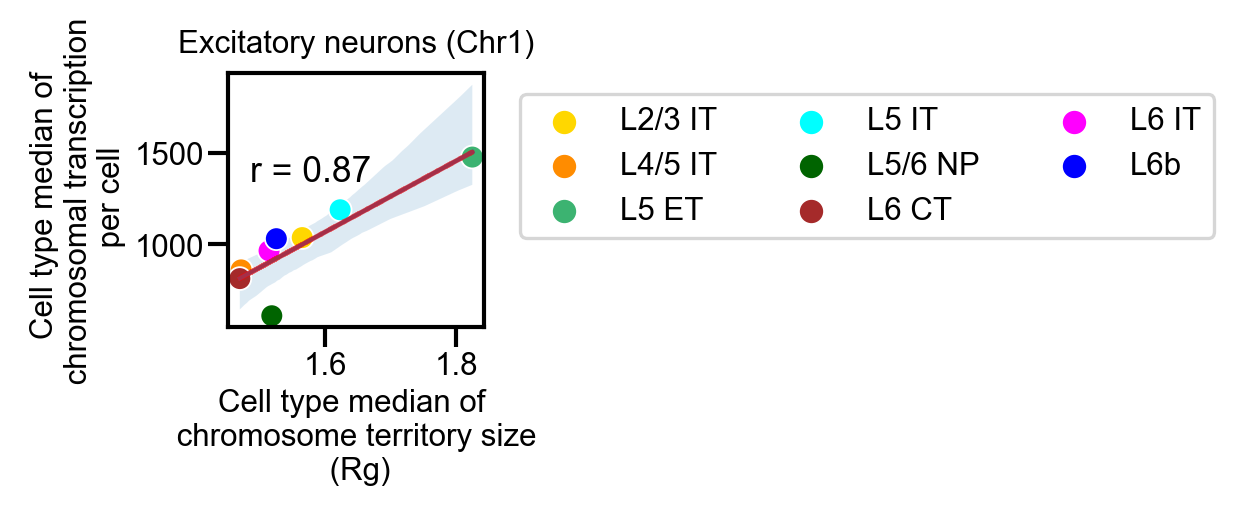

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.14s/it]meta NOT subset; don't know how to subset; dropped


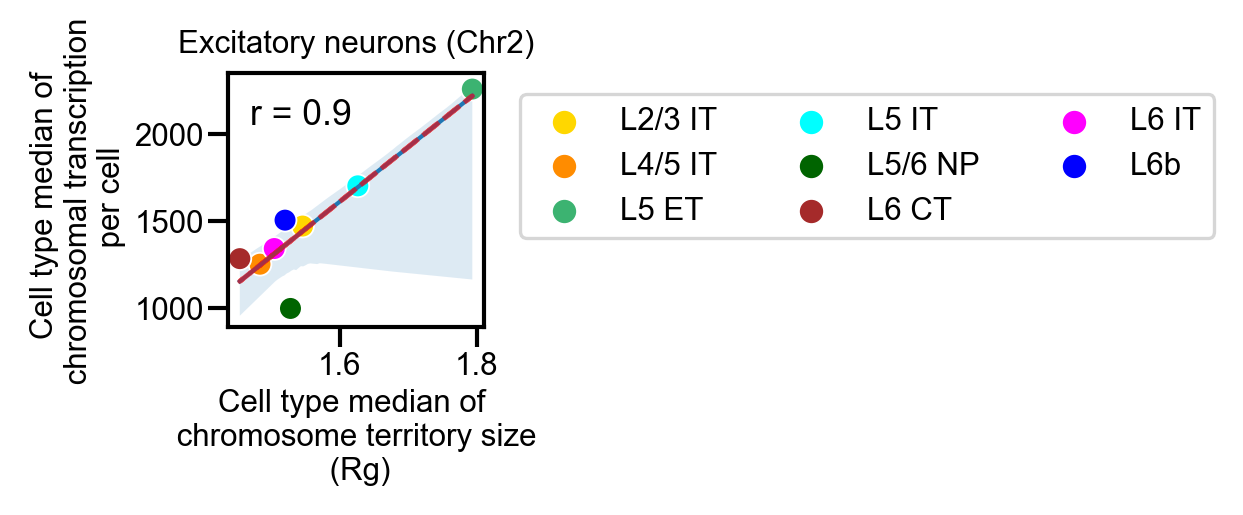

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.23s/it]meta NOT subset; don't know how to subset; dropped


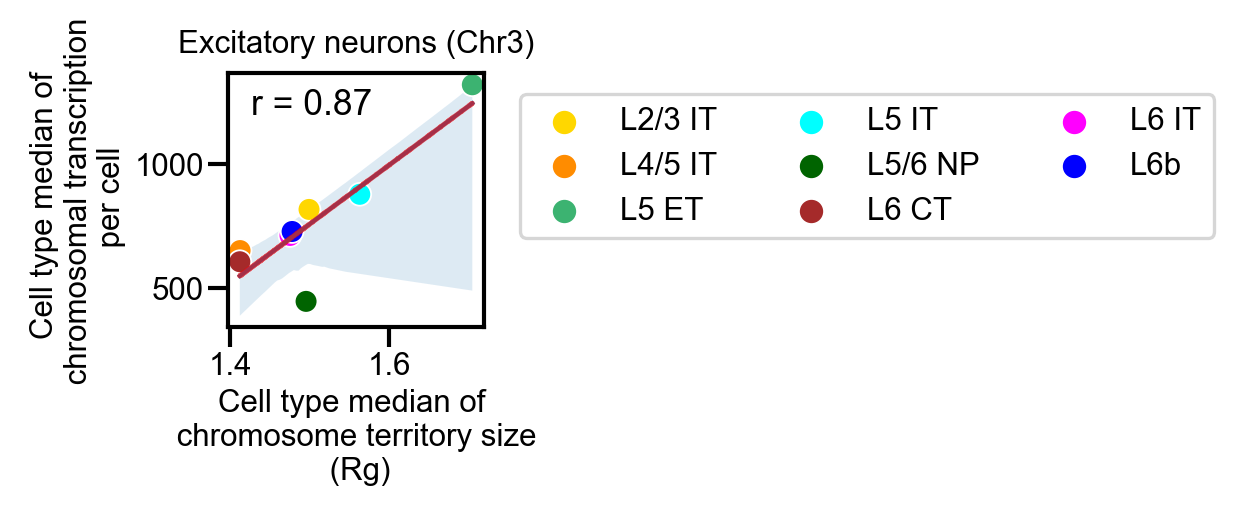

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


In [22]:
%matplotlib inline
import seaborn as sns

sel_chrom_list = ['1','2','3']
for sel_chrom in tqdm.tqdm(sel_chrom_list):
    sel_chrom = f'chr{sel_chrom}'
    expression_chr_df_sub = expression_chr_df[expression_chr_df['chr']==sel_chrom]
    expression_chr_df_sub = expression_chr_df_sub [expression_chr_df_sub ['celltype'].isin(Gluta_list)].copy(deep=True)
    
    fig, ax = plt.subplots(figsize=(_page_width/5,_page_width/5),dpi=300)
    
    x_col = 'chrom_size'
    
    gfg = sns.regplot(data=expression_chr_df_sub, x= x_col, y='chromosome_expression', ax=ax, ci=95,
                  line_kws={'linewidth':1},scatter=False,
                 )
    sns.scatterplot(ax=ax, data=expression_chr_df_sub, x=x_col,y='chromosome_expression',
                        hue='celltype', legend = 'brief', palette=celltype_palette,
                    s=30)
    ax.set_title(f'{sel_chrom}',fontsize=_font_size)

    # correlation
    X=expression_chr_df_sub[x_col].values.reshape(-1, 1)
    y=expression_chr_df_sub['chromosome_expression'].values.reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True).fit(X, y)
    y_pred = reg.predict(X)
    ax.plot(X,y_pred,'r--',alpha=0.6)
    rPlot_x,rPlot_y = np.nanmin(X)*1.01, np.nanmax(y)*.91
    #ax.text(rPlot_x,rPlot_y,f'r\u00b2 = {round(reg.score(X, y),2)}',fontsize=_font_size)
    
    from scipy.stats import pearsonr
    r_val = pearsonr(expression_chr_df_sub[x_col].values, expression_chr_df_sub['chromosome_expression'].values)[0]
    ax.text(rPlot_x,rPlot_y,f'r = {round(r_val,2)}',fontsize=_font_size+1)

    
    plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left', borderaxespad=1,fontsize=_font_size,ncols=3)
    ax.set_ylabel('Cell type median of \n chromosomal transcription \n per cell',fontsize=_font_size,labelpad=2)
    ax.set_xlabel(f'Cell type median of \n chromosome territory size \n (Rg)', fontsize=_font_size, labelpad=2)
    
    ax.set_title(f'Excitatory neurons ({sel_chrom.capitalize()})',fontsize=_font_size,pad=5)
    
    ax.tick_params('x', labelsize=_font_size, 
                    #width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for _ax
    ax.tick_params('y', labelsize=_font_size, 
                #width=_ticklabel_width, #length=0,
                pad=1, labelleft=True)
    
    #plt.xlim([1.4,1.85])
    #plt.ylim([800,1700])
    plt.savefig(os.path.join(output_figure_folder, f'Corr_Chromosome_Rg_and_Transcription_{sel_chrom}_ExcNeu.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

    #plt.tight_layout()
    plt.show()